<a href="https://colab.research.google.com/github/gdoorash/Cassava-Disease-Classification/blob/master/Cassava-Disease-Classification/Notebooks/Pipeline__Model_Pretrained_cassava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ResNet_Pretrained Architecture**

In [0]:
import numpy
import torch 
import torchvision 
import os
import matplotlib.pyplot as plt
import random 
import pdb
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import imageio
import PIL
from IPython import display
from torchvision import datasets
import torch.nn as nn
import copy

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
!unzip "/content/gdrive/My Drive/Colab Notebooks/Data/Cassava_t_v_t.zip";

Streaming output truncated to the last 5000 lines.
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1341.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1344.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1345.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1346.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1347.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1348.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1349.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-135.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1351.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1352.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1354.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1356.jpg  
  inflating: ammi-2020-convnets/train/train/cbsd/train-cbsd-1357.jpg  
  inflating: ammi-2020-conv

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
# Load Cassava dataset
traindata_folder_path = '/content/ammi-2020-convnets/train/train/'
valdata_folder_path = '/content/ammi-2020-convnets/train/validation/'
testdata_folder_path = '/content/ammi-2020-convnets/test/test/'


# load the extra data for self-supervie (Autoencodrer)..
extra_folder_path = '/content/ammi-2020-convnets/extraimages/'


## **Dataset and DataLoader**

In [2]:
######################### Transformations of images #################################################


inference_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.CenterCrop(400),
    # transforms.RandomGrayscale(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomRotation((-90,+90)),
    transforms.ColorJitter((0.5, 1.7), (0.8, 1.7)),
    transforms.ToTensor(),
    transforms.Normalize([0.4479, 0.4963, 0.3217], [0.2074, 0.2087, 0.1896])
   
])

test_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(), 
    transforms.Normalize([0.4479, 0.4963, 0.3217], [0.2074, 0.2087, 0.1896]) 
])


########################################   Transform and put the data into Dataset object #########################################################################

transformed_cassava_trian = datasets.ImageFolder(traindata_folder_path, transform=inference_transform)
transformed_cassava_validation = datasets.ImageFolder( valdata_folder_path, transform=inference_transform) 
transformed_cassava_test = datasets.ImageFolder(testdata_folder_path, transform=test_transform)

##########################################  Load the data into DataLoader #########################################################
transformed_cassava_trainloader = torch.utils.data.DataLoader(transformed_cassava_trian, batch_size=32, shuffle=False, sampler=weighted_sampler, num_workers=11)
transformed_cassava_valloader = torch.utils.data.DataLoader(transformed_cassava_validation, batch_size=16, shuffle=False, num_workers=11)
transformed_cassava_testloader = torch.utils.data.DataLoader(transformed_cassava_test, batch_size=16, shuffle=False )




########## Extra data set loading ##########################################################################

transformed_cassava_extra = datasets.ImageFolder(extra_folder_path, transform=inference_transform,)
transformed_cassava_extraloader = torch.utils.data.DataLoader(transformed_cassava_extra , batch_size=64, shuffle=True, num_workers=8)



NameError: ignored

### prepare weightedSampler 

In [14]:
transformed_cassava_trian.class_to_idx.items()

dict_items([('cbb', 0), ('cbsd', 1), ('cgm', 2), ('cmd', 3), ('healthy', 4)])

In [0]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [16]:
target_list = torch.tensor(transformed_cassava_trian.targets)
target_list = target_list[torch.randperm(len(target_list))]
len(target_list)

5331

In [17]:
idx2class = {v: k for k, v in transformed_cassava_trian.class_to_idx.items()}
idx2class

{0: 'cbb', 1: 'cbsd', 2: 'cgm', 3: 'cmd', 4: 'healthy'}

In [18]:
class_count = [i for i in get_class_distribution(transformed_cassava_trian).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

tensor([0.0025, 0.0007, 0.0014, 0.0004, 0.0040])

In [19]:
class_weights_all = class_weights[target_list]
class_weights_all

tensor([0.0004, 0.0004, 0.0014,  ..., 0.0014, 0.0007, 0.0004])

In [0]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

### Dataset and Dataloader

## **Train and Test functios**

In [0]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [0]:
train_losses = []
valid_losses = []

def train (model, criterion, train_dataloader, valid_dataloader, optimizer, num_epochs,  path, start_epoch=0):
    
    
    
    # move the model to GPU
    model.to(device)
    
    
    best_acc = 0.0
    torch.save({'best_val_acc':best_acc ,'epoch': start_epoch, 'optimizer': optimizer.state_dict(), 'model_dict': model.state_dict()}, path) 
    
    




    print("# Start training...")
    for epoch in range(start_epoch, start_epoch + num_epochs):
      
      train_loss = 0
      train_n_iter = 0
      tcorrect = 0

      # put the model in train mode
      model.train()
     
      for batch_index, (batch, target) in enumerate(train_dataloader):
          batch = batch.to(device)
          target = target.to(device)
          
          optimizer.zero_grad()
          
          # Forward step 
          output = model(batch)
          loss = criterion(output.to(device), target)
          
          # Backward step 
          loss.backward()
          #gradient step
          optimizer.step()
          

          # compute the accuracy
          prediction = output.argmax(dim=1, keepdim=True)
          tcorrect += prediction.cpu().eq(target.cpu().view_as(prediction)).sum().item()

          # avarge of loss
          train_loss += loss.item()
          train_n_iter += 1

      valid_loss = 0
      valid_n_iter = 0
      vcorrect = 0
      model.eval()
      #iterate over valid data..
      for images, labels in transformed_cassava_valloader:
        images = images.to(device)
        labels = labels.to(device)

        #forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # compute accuracy
        prediction = outputs.argmax(dim=1, keepdim=True)
        vcorrect += prediction.cpu().eq(labels.cpu().view_as(prediction)).sum().item()
        
        # loss and accuracy
        valid_loss += loss.item()
        valid_n_iter += 1

      




      train_losses.append(train_loss/train_n_iter)
      valid_losses.append(valid_loss/valid_n_iter)
   
      train_percent = 100. * tcorrect / len(train_dataloader.dataset)
      valid_percent = 100. * vcorrect / len(valid_dataloader.dataset)
      DF = train_percent-valid_percent 

      # Print out progress the end of epoch.
      print('\nEpoch:{}/{} \tTrain Loss: {:.4f} \tValid Loss: {:.4f} -------- Train Accuracy: {} \tValid Accuracy: {}\tDF: {}'.format(
         epoch + 1, start_epoch + num_epochs,
        train_loss/train_n_iter, valid_loss / valid_n_iter,
        train_percent, valid_percent, DF ))
      

      if  valid_percent > best_acc:
                best_acc = valid_percent
                torch.save({'best_val_acc':best_acc ,'epoch': epoch, 'optimizer': optimizer.state_dict(), 'model_dict': model.state_dict()}, path)  #copy.deepcopy(model.state_dict()) 
        
     
      

def test (model, criterion, dataloader):
    
    model.eval()
    correct = 0
    # avg_loss = 0
    with torch.no_grad():
        
        for data, target in dataloader:
             
            data = data.to(device)
            target = target.to(device)
            
            output = model(data).to(device)
            # loss = criterion(output, target) 
            
            prediction = output.argmax(dim=1, keepdim=True) 
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            
            # avg_loss += loss.item() 
    percent = 100. * correct / len(dataloader.dataset)
    print(f'Accuracy: {correct}/{len(dataloader.dataset)} ({percent:.0f}%)')
   
    return percent  
    
    
    
        
        
            

## **Model Architecture (ResNet)** 

In [0]:
# define the per-trained model...
full_resnet_model = torchvision.models.resnet152(pretrained=True)
# full_resnet_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnext50_32x4d', pretrained=False)
# full_resnet_model

In [0]:
class ModelResNet(nn.Module):

  def __init__(self):
    super(ModelResNet, self).__init__()
    self.res_mod = nn.Sequential(*list(full_resnet_model.children())[:-4])
    # self.maxpool = nn.MaxPool2d(3)
    self.avgpool = nn.AdaptiveAvgPool2d(1)
   
    self.fc =  nn.Linear(512, 5)
   

  def forward(self, x):
      x = self.res_mod(x)
      # x = self.maxpool(x)
      x = self.avgpool(x)
      x = self.fc(x.view(x.size(0), -1))
      
      return x

In [27]:
# Model Architectuer..
model = ModelResNet()
model
x = torch.randn((32, 3, 500, 500))
model(x).shape

torch.Size([32, 5])

## **Checkpoint load & setup the Optimizer, Criterion..**

In [0]:
# # Create checkpoint ...
path_checkpoints = "/content/gdrive/My Drive/Colab Notebooks/model_data_checkpoints/ResNet/resnet152cp_4Wed6520-2pm.pt"
# torch.save(model.state_dict(), path)

In [0]:
# # load the checkpoint...
# model = model.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/model_data_checkpoints/ResNet/resnetcp_2.pt"))
# # model

In [0]:

load_pretrained = True
start_epoch = 0
if load_pretrained:
    if not os.path.exists(path_checkpoints):
        raise EOFError('No model downloaded!')
    model_params = torch.load(
        path_checkpoints,
        map_location=torch.device(device)
    )
    
    start_epoch = model_params['epoch']
    model = ModelResNet().to(device)
    model.load_state_dict(  model_params['model_dict'])
    optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4, weight_decay=0.001)
    optimizer.load_state_dict(model_params['optimizer'])
    
else:
    
    num_epochs = 150 
    optimizer = torch.optim.Adamax(model.parameters(), lr=1e-4, weight_decay=0.001)
    model = ModelResNet().to(device)

criterion = nn.CrossEntropyLoss()


In [30]:
model_params['epoch']
# num_epochs = 130 

117

## Let's go to TRAIN!!!!

In [20]:
train(model, criterion, transformed_cassava_trainloader,  transformed_cassava_valloader, optimizer, num_epochs, path_checkpoints, start_epoch)

# Start training...

Epoch:17/130 	Train Loss: 0.4930 	Valid Loss: 0.6038 -------- Train Accuracy: 84.2055899456012 	Valid Accuracy: 78.15384615384616	DF: 6.051743791755044

Epoch:18/130 	Train Loss: 0.4690 	Valid Loss: 0.6475 -------- Train Accuracy: 85.04970924779592 	Valid Accuracy: 79.07692307692308	DF: 5.972786170872837

Epoch:19/130 	Train Loss: 0.4531 	Valid Loss: 0.6286 -------- Train Accuracy: 85.91258675670606 	Valid Accuracy: 80.92307692307692	DF: 4.989509833629143

Epoch:20/130 	Train Loss: 0.4411 	Valid Loss: 0.6258 -------- Train Accuracy: 85.76252110298256 	Valid Accuracy: 76.92307692307692	DF: 8.839444179905641

Epoch:21/130 	Train Loss: 0.4389 	Valid Loss: 0.6256 -------- Train Accuracy: 85.46238979553554 	Valid Accuracy: 72.3076923076923	DF: 13.154697487843237

Epoch:22/130 	Train Loss: 0.4233 	Valid Loss: 0.5793 -------- Train Accuracy: 86.7191896454699 	Valid Accuracy: 78.15384615384616	DF: 8.565343491623736

Epoch:23/130 	Train Loss: 0.4047 	Valid Loss: 0.5991 ----

In [47]:
model_params['epoch']

117

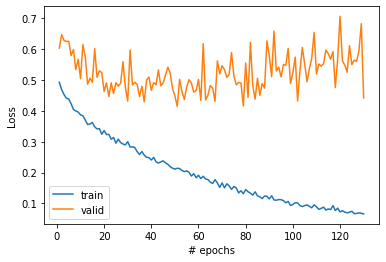

In [22]:
# Save history for later
train_loss_history = train_losses
valid_loss_history = valid_losses

# Plot training and validation curve
x = range(1, 130 + 1)
plt.plot(x, train_loss_history, label='train')
plt.plot(x, valid_loss_history, label='valid')


plt.xlabel('# epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## **Submission** 

In [0]:
submission_file_path = "/content/ammi-2020-convnets/sample_submission_file.csv"
testloader = transformed_cassava_testloader
train_class_indices = transformed_cassava_trian.class_to_idx

In [0]:
from PIL import Image
test_path ='/content/ammi-2020-convnets/test/test/0'


In [0]:

def get_single_batch(base_dir, filenames, image_size):
    output = torch.zeros((len(filenames), 3, image_size, image_size))
    for i in range(len(filenames)):
        image_numpy = Image.open(os.path.join(test_path, filenames[i]))
        output[i] = test_transform(image_numpy)
    return output

def get_batches(base_dir, filenames, image_size, batch_size=32):
    i = 0
    while i < len(filenames):
        image_files = filenames[i:i+batch_size]
        yield get_single_batch(base_dir, image_files, image_size)
        i+= batch_size

In [0]:
import pandas as pd
import numpy as np
image_size = 400

def create_submission(model, directory, sample_submission_file, class2index, batch_size=2):
    
    ss_df = pd.read_csv(sample_submission_file)
    
    index2class = {value:key for key, value in class2index.items()}
    labels = []
    model.eval()
    filenames = ss_df["Id"].values.tolist()
    for batch in get_batches(directory, filenames, image_size, batch_size):
        prediction = model(batch.to(device))
        for p in prediction:
            labels.append(index2class[p.argmax().item()])
    ss_df["Category"] = labels
    return ss_df

In [0]:
submission = create_submission(model, test_path, submission_file_path, train_class_indices)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


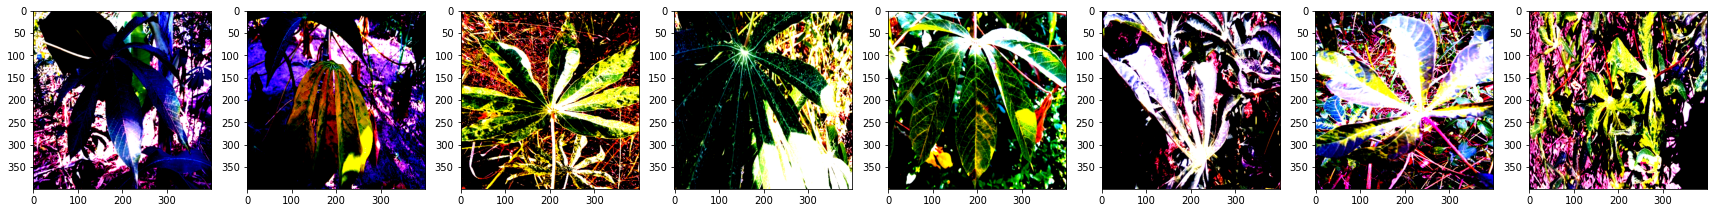

In [133]:
fig, ax = plt.subplots(1,8)
fig.set_size_inches(30, 11)
for i, (batch,_) in enumerate(transformed_cassava_testloader):
  for b, image in enumerate(batch):
    if b == 8:
      break
    transformed_image = np.transpose(image.numpy(), (1, 2, 0))
    ax[b].imshow(transformed_image)
  break

In [50]:
submission

,Category,Id
0,cbsd,test-img-0.jpg
1,cbb,test-img-1.jpg
2,cmd,test-img-2.jpg
3,cmd,test-img-3.jpg
4,cmd,test-img-4.jpg
...,...,...
3769,cbsd,test-img-3769.jpg
3770,cmd,test-img-3770.jpg
3771,cmd,test-img-3771.jpg
3772,cbb,test-img-3772.jpg


In [0]:
submission.to_csv('submission.csv', index=False)

In [0]:
!kaggle competitions submit -c ammi-2020-convnets -f ../output/kaggle/working/submission.csv -m "torch-starter sumbission"